# Лабораторная работа №5. Сверточные нейронные сети

В данной лабораторной работе рассматривается решение задачи классификации посредством свёрточных нейронных сетей.
Для построения сетей предлагается использовать [Keras](https://keras.io) на базе [TensorFlow](https://www.tensorflow.org).

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
import sklearn as sk
import sklearn.datasets
import sklearn.model_selection

mpl.rcParams['axes.grid'] = True

print("tensorflow =", tf.__version__, "keras =", tf.keras.__version__)
if tuple(map(int, tf.__version__.split('.'))) < (2, 5, 0):
    tf.autograph.set_verbosity(0)
    import logging
    logging.getLogger("tensorflow").setLevel(logging.ERROR)

tensorflow = 2.7.0 keras = 2.7.0


## Задание №1

Загрузите датасет MNIST с помощью вызова `tf.keras.datasets.mnist.load_data()`.
Промасштабируйте обучающую и тестовую выборки, чтобы входные значения лежали в отрезке $[0; 1]$.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.float32(x_train / x_train.max()).reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
y_train = y_train.reshape(y_train.shape[0], 1)

x_test = np.float32(x_test / x_test.max()).reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

print(x_train.dtype, x_train.shape, y_train.shape)
assert x_train.dtype == np.float32 and x_test.dtype == np.float32, 'Неправильный тип входных данных'
assert x_train.shape[1:] == (28, 28, 1) and x_test.shape[1:] == (28, 28, 1), 'Неправильная размерность входных данных'
assert (x_train <= 1).all() and (x_test <= 1).all(), 'Неправильный диапазон входных данных'

float32 (60000, 28, 28, 1) (60000, 1)


Изучите приведённую ниже сеть с архитектурой:

1. Свёточный слой с 16 фильтрами размера $3\times3$ и функцией активации relu
1. Слой MaxPooling с размером шага 2
1. Свёточный слой с 32 фильтрами размера $3\times3$ и функцией активации relu
1. Слой MaxPooling с размером шага 2
1. Свёточный слой с 64 фильтрами размера $3\times3$ и функцией активации relu
1. Слой линеаризации
1. Полносвязный слой с количеством нейронов равным количеству выходных классов с функцией активации softmax

В качестве градиетного спуска выступает SGD, размер батча определяется при обучении модели.
Для вычисления функции потерь используется кросс-энтропия по категориям с автоматическим OneHot кодированием.
Метрика точности соответствует $accuracy(\tilde{y}, y) = \frac{1}{N} \sum_{n=0}^{N-1} 1(\tilde{y}_n = y_n)$.
При этом точное название метрики `sparse_categorical_accuracy`, которое можно сократить до `accuracy`, так как метрика выбирается согласно функции потерь.

Запустите нейросеть.
Итоговая точность должна получится около 92% или больше.

In [ ]:
%%time

def create_model1(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = create_model1(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=3, validation_data=(x_test, y_test), verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

y_pred = model(x_test)
print('y_test', y_test[:2], 'y_pred', y_pred[:2])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496 

**Вопросы**:

1. Сколько всего параметров у нейронной сети?
1. Сколько всего участвует в обучении векторов из обучающей выборки?
1. Какая точность достигнута?
1. В обучающей выборке в качестве классов используются числа от 0 до 9.
Что получается на выходе у нейронной сети?
Как выходные значения нейронной сети преобразовать в номер класса?

**Ответы**:

1. Всего у сети 54666 параметров.
1. В обучении участвует 60000 векторов обучающей выборки.
1. Достигнутая точность составляет $94\%$.
1. На выходе у нейронной сети получается вектор, элементы которого соответсвуют вероятностям принадлежности входного изображения к рассматриваемым классам,  i-й элемент вектора соотвествует i-му классу. Поэтому можно считать, что входное изображение принадлежит классу, номер которого равен номеру наибольшего элемента соотвествующего выходного вектора.

## Задание №2

Попробуйте увеличить точность классификации, например, добавив после каждого свёрточного слоя нормализацию (BatchNormalization) или изменив архитектуру сети.
Объясните целесообразность произведенных изменений.

Добавим слои BatchNormalization после каждого слоя MaxPooling и после слоя Flatten. Слои BatchNormalization масштабируют входной сигнал, что позволяет сократить время обучения сети. Использование нескольких слоёв BatchNormalization необходимо потому, что при прохождении через очередной полносвязный или свёрточный слой даже предварительно отнормированные данные теряют нормировку в результате преобразований, вызванных этими слоями.

In [ ]:
%%time

def create_model2(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model


model = create_model2(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=3, validation_data=(x_test, y_test), verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

y_pred = model(x_test)
print('y_test', y_test[:2], 'y_pred', y_pred[:2])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 7, 7, 32)         0   

Рассмотрим вариант с BatchNormalization слоями до слоёв MaxPooling.

In [ ]:
%%time

def create_model3(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model


model = create_model3(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=3, validation_data=(x_test, y_test), verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

y_pred = model(x_test)
print('y_test', y_test[:2], 'y_pred', y_pred[:2])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 batch_normalization_16 (Bat  (None, 28, 28, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 batch_normalization_17 (Bat  (None, 14, 14, 32)       128 

**Вопросы:**

1. Почему появились необучаемые параметры (non-trainable)?
1. Распишите, какие и сколько параметров входят в BatchNormalization. Для этого воспользуйтесь переменной `layers` и методом `get_weights`.
1. Сколько параметров используется на каждом batch normalization слое?
1. Какая итоговая точность получилась? Стала ли она больше?
1. Как введение новых слоёв повлияло на время обучения сети?
1. Попробуйте поставить BatchNormalization слои перед/после MaxPooling. Как меняются характеристики и время обучения?

**Ответы:**

1. Необучаемые параметры - параметры слоя BatchNormalization, которые не изменяются в процессе обучения.
1. В BatchNormalization входят $4n$ параметров, где $n$ - количество параметров измерения, вдоль которого происходит нормализация, 4 параметра для каждого из $n$ элементов - это `gamma weights, beta weights, moving_mean(non-trainable), moving_variance(non-trainable)`. Например, у первого BatchNormalization слоя $n = 16$ и общее число параметров равно 64.
1. $4n$ параметров, где $n$ - количество параметров измерения, вдоль которого происходит нормализация.
1. Итоговая точность увеличилась и теперь составляет более $98\%$.
1. Время обучения возросло с 4 минут 56 секунд до 5 минут 55 секунд (более чем на $16\%$).
1. При расположении BatchNormalization слоёв после MaxPooling первые будут иметь меньше параметров. Время обучения при этом также снижается.

## Задание №3

Визуализируйте результат воздействия весов последней сети с первого свёрточного слоя на одно из тестовых изображений.

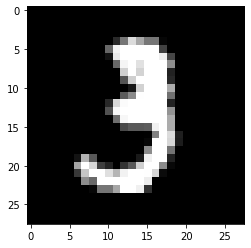

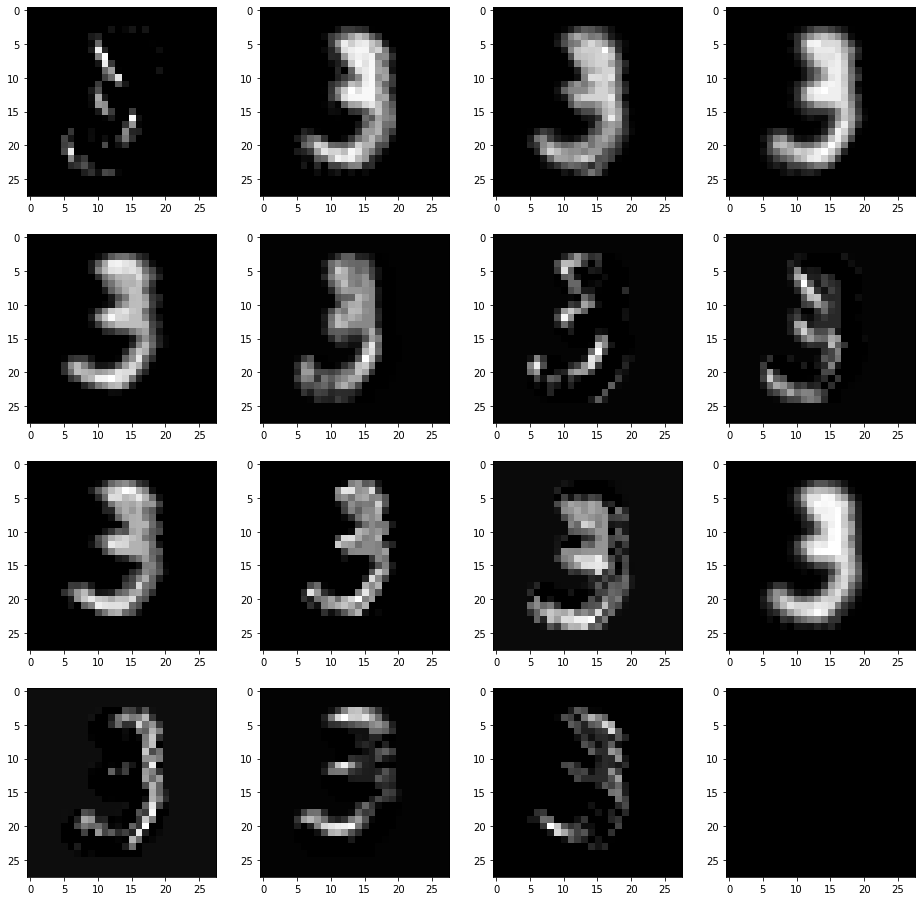

In [ ]:
layer = model.get_layer(index=1)
p = layer(x_train[10:11])

plt.grid(False)
plt.imshow(x_train[10, :, :, 0], cmap='gray')

fig, axes = plt.subplots(4, 4, figsize=(4*4, 4*4))
k = 0
for row, ax_rows in enumerate(axes):
    for col, ax in enumerate(ax_rows):
        ax.imshow(p[0,:,:,k], cmap='gray')
        ax.grid(False)
        k += 1

**Вопросы:**

1. На что похожи отклики с первого слоя?

**Ответы:**

1. Некоторые отклики первого слоя похожи на контуры и отдельные фрагменты изображения, поданного на вход, некоторые - на его более сглаженную версию.

## Задание №4

Подготовьте датасет [cifar10](https://keras.io/api/datasets/) аналогично предыдущему датасету.
Во время первого запуска будет скачиваться архив (около 170 МБ).
Он будет закеширован локально, поэтому последующие загрузки этого датасета будут занимать меньше времени.

Покажите 4 произвольных изображения из обучающей выборки.

170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) float32 (50000, 1) uint8 (10000, 1)


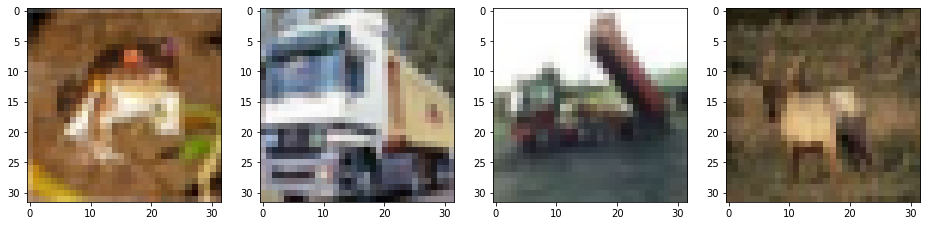

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = np.float32(x_train / x_train.max())

x_test = np.float32(x_test / x_test.max())

print(x_train.shape, x_train.dtype, y_train.shape, y_train.dtype, y_test.shape)

assert x_train.dtype == np.float32 and x_test.dtype == np.float32, 'Неправильный тип входных данных'
assert (x_train <= 1).all() and (x_test <= 1).all(), 'Данные не отмасштабированы'

fig, axes = plt.subplots(1, 4, figsize=(4*4, 4*4))
k = 0
for ax in axes:
  ax.imshow(x_train[k])
  ax.grid(False)
  k += 1

Постройте сеть с такой архитектурой:
```
convolution2dLayer: 32, 3x3, 'Padding'=1
reluLayer
maxPooling2dLayer: 2, 'Padding'=0

convolution2dLayer: 32, 3x3, 'Padding'=1
reluLayer
maxPooling2dLayer: 2, 'Padding'=0
       
convolution2dLayer: 64, 3, 'Padding'=1
reluLayer
maxPooling2dLayer: 2, 'Padding'=0

fullyConnectedLayer: 128
reluLayer 
fullyConnectedLayer: num_classes
softmaxLayer
```

Изображения цветные, поэтому для первого слоя с конволюцией укажите параметр `data_format='channels_last'`.
При обучении используйте 15 эпох, размер батча 128, оптимизатор градиентного спуска - SGD.
Также можно использовать любую другую архитектуру, объяснив целесообразность её применения.
Протестируйте работу данной сети.
Время обучения сети 5-10 минут.

In [ ]:
%%time

def create_model4(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', data_format='channels_last')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units = 128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model


model = create_model4(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_test, y_test), verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 8, 8, 64)          1849

**Вопросы:**

1. Какую точность классификации удалось получить?
1. Какие слои не имеют параметров обучения? Почему?
1. Какую размерность имеют входные изображения?

**Ответы:**

1. Точность классификации составляет примерно $55\%$
1. Слои MaxPooling и Flatten не имеют обучаемых параметров, т. к. для определения максмального значения, и изменения размерности данных параметры не требуются.
1. Входные изображения имеют размерность 32x32x3.

## Задание №5

Попробуйте улучшить точность классификации, добавив нормализацию после свёрточных и полносвязных слоёв.

In [ ]:
%%time

def create_model5(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', data_format='channels_last')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units = 128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = create_model5(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_test, y_test), verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_23 (Bat  (None, 16, 16, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_33 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 8, 8, 32)         0   

**Вопросы:**

1. Удалось ли увеличить точность классификации введением новых слоёв?
1. Как изменилось время обучения сети? (Обратите внимание на `Wall time`, `total`, а также на время обучения каждой эпохи)

**Ответы:**

1. Точность классификации увеличилась до $67\%$.
1. `CPU times` увеличилось с 19 минут 27 секунд до 20 минут 30 секунд, `total` - с 35 минут 4 секунд до 38 минут 5 секунд, `Wall time` с 19 минут 27 секунд до 20 минут 30 секунд. Время обучения на каждой эпохе увеличилось в среднем на 7 секунд.

## Задание №6

Попробуйте добавить слой dropout `tf.keras.layers.Dropout(<probability>)` после полносвязного слоя, подобрав оптимальную на Ваш взгляд вероятность удаления нейронов.
Поэкспериментируйте с добавлением слоёв BatchNormalization и без них.

В для борьбы с переобучением на каждой эпохе будем делать проверку точности и сохранять веса модели, которые являются оптимальными в смысле максимума точности на тестовой выборке.

In [11]:
%%time

best_model = [tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)]

def create_model6(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', data_format='channels_last')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units = 128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate = 0.1)(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = create_model6(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_test, y_test), callbacks=best_model, verbose=True)
model.load_weights('best_model.h5')
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 16, 16, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 8, 8, 32)         0   

Рассмотрим вариант с Dropout, но без BatchNormalization слоёв.

In [14]:
%%time

best_model = [tf.keras.callbacks.ModelCheckpoint(filepath='best_model_without_bn.h5', monitor='val_accuracy', save_best_only=True)]

def create_model7(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', data_format='channels_last')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units = 128, activation='relu')(x)
    x = tf.keras.layers.Dropout(rate = 0.1)(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = create_model7(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_test, y_test), callbacks=best_model, verbose=True)
model.load_weights('best_model_without_bn.h5')
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 8, 8, 64)          184

Более целесообразным получению наибольшей точности представляется разместить слой Dropout не после полносвязного слоя Dense, а после слоя преобразования размерности Flatten. В первом случае мы применяем Dropout к сигналу, поступающему на вход последнего слоя с Softmax, что, скорее всего, негативно сказывается на точности. Во втором случае такой ситуации не происходит.

In [13]:
%%time

best_model = [tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)]

def create_model8(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', data_format='channels_last')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(rate = 0.1)(x)
    x = tf.keras.layers.Dense(units = 128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = create_model8(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_test, y_test), callbacks=best_model, verbose=True)
model.load_weights('best_model.h5')
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_28 (Bat  (None, 16, 16, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_28 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 8, 8, 32)         0   

**Вопросы:**

1. Удалось ли увеличить точность классификации?
1. Что влияет больше на увеличение точности: слой Dropout или BatchNormalization?
1. Как изменилось время обучения?

**Ответы:**

1. Да, точность классификации увеличилась. Для данной задачи применение только слоёв Dropout без BatchNormalization уменьшает итоговую точность на $1\%$, по сравнению со случаем, когда методы регуляризации не используются совсем. Разместив Dropout непосредственно после слоя Flatten удалось добиться $69.5\%$ точности.
1. Для данной конкретной задачи использование BatchNormalization оказало большее влияение на увеличение точности, чем Dropout.
1. Время обучения увеличилось.